In [2]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

import warnings
warnings.filterwarnings("ignore")

In [3]:
# replace lighting.pytorch as pytorch_lightning
# from pytorch_forecasting import BaseModel

In [4]:
from scripts.data_builder import HydroForecastData
from scripts.tft_data import file_checker, open_for_tft, train_val_split
from scripts.model_eval import pred_res_builder

import glob
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from copy import deepcopy

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import (TimeSeriesDataSet, TemporalFusionTransformer,
                                 Baseline)
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss, SMAPE, RMSE, MASE
from pytorch_forecasting.metrics.base_metrics import MultiHorizonMetric
from sklearn.preprocessing import RobustScaler, MinMaxScaler

# torch.set_float32_matmul_precision('medium')
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')
meteo_input = ['prcp_e5l',  't_max_e5l', 't_min_e5l']
hydro_target = 'q_mm_day'

ws_file = gpd.read_file('../geo_data/great_db/geometry/russia_ws.gpkg')
ws_file = ws_file.set_index('gauge_id')
# ws_file = ws_file[ws_file['new_area'] <= 50000]

Using device: cuda

NVIDIA GeForce RTX 3080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Model

In [50]:
def interpretation_for_gauge(interp_dict: dict,
                             static_parameters: list,
                             encoder_params: list,
                             decoder_params: list):

    def to_percentage(values: torch.Tensor):
        values = values / values.sum(-1).unsqueeze(-1)
        return values

    def interp_df(interp_tensor: torch.Tensor,
                  df_columns: list):
        interp_tensor = to_percentage(interp_tensor)

        interp = {var: float(val) for var, val in zip(df_columns,
                                                      interp_tensor)}
        interp = pd.DataFrame(interp, index=[0])

        return interp

    # find most informative days
    _, indices = interp_dict['attention'].sort(descending=True)
    indices = indices[0]+1
    # get most valuable static parameters
    static_worth = interp_df(interp_tensor=interp_dict['static_variables'],
                             df_columns=static_parameters)
    stat_cols, _ = (list(static_worth.T.nlargest(n=4, columns=0).T.columns),
                   list(static_worth.T.nlargest(n=4, columns=0).T.to_numpy()))
    
    # get most valuable encoder parameters
    encoder_worth = interp_df(interp_tensor=interp_dict['encoder_variables'],
                              df_columns=encoder_params)
    enc_col, _ = (encoder_worth.idxmax(axis=1)[0],
                  encoder_worth.max(axis=1)[0])
    # get most valuable decoder parameters
    decoder_worth = interp_df(interp_tensor=interp_dict['decoder_variables'],
                              df_columns=decoder_params)
    dec_col, _ = (decoder_worth.idxmax(axis=1)[0],
                  decoder_worth.max(axis=1)[0])

    return int(indices), stat_cols, enc_col, dec_col

In [ ]:
open_for_tft(
        nc_files=[nc_file],
        static_path='../geo_data/attributes/geo_vector.csv',
        area_index=ws_file.index,
        meteo_predictors=meteo_input,
        hydro_target=hydro_target, allow_nan=True)

In [ ]:
by_gauge_res = list()
for nc_file in glob.glob('../geo_data/great_db/nc_all_q/*.nc'):
    gauge_id = nc_file.split('/')[-1][:-3]

    file = open_for_tft(
        nc_files=[nc_file],
        static_path='../geo_data/attributes/geo_vector.csv',
        area_index=ws_file.index,
        meteo_predictors=meteo_input,
        hydro_target=hydro_target)

    (train_ds, train_loader,
        val_ds, val_loader, val_df,
        scaler) = train_val_split(file)

    # configure network and trainer
    early_stop_callback = EarlyStopping(monitor="val_loss",
                                        min_delta=1e-3, patience=3,
                                        verbose=True, mode="min")
    # log the learning rate
    lr_logger = LearningRateMonitor()
    # logging results to a tensorboard
    logger = TensorBoardLogger(f"./single_gauge_8epoch/{gauge_id}_tft")

    if device == 'cuda':
        accel = 'gpu'
    else:
        accel = 'cpu'

    trainer = pl.Trainer(
        max_epochs=8,
        accelerator='auto',
        enable_model_summary=True,
        check_val_every_n_epoch=3,
        gradient_clip_val=0.5,
        log_every_n_steps=3,
        callbacks=[lr_logger, early_stop_callback],
        logger=logger)

    tft = TemporalFusionTransformer.from_dataset(
        train_ds,
        learning_rate=1e-3,
        hidden_size=64,
        dropout=0.4,
        loss=nnse(),
        optimizer='adam')

    # print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

    # fit network
    trainer.fit(tft,
                train_dataloaders=train_loader,
                val_dataloaders=val_loader)

### Result evaluation

In [4]:
from pytorch_forecasting.metrics import RMSE

class nnse(MultiHorizonMetric):

    def loss(self, pred, target):

        pred = self.to_prediction(pred)
        denom = torch.sum((target-pred)**2)
        divsr = torch.sum((target - torch.mean(target)**2))
        nse = 1 - torch.div(denom, divsr)
        nnse = 1 / (2 - nse)

        return nnse


def nse(pred, target):
    denom = np.sum((target-pred)**2)
    divsr = np.sum((target-np.mean(target))**2)
    return 1-(denom/divsr)

In [5]:
q_indexes = [i.split('/')[-1][:-3] for i in
             glob.glob('../geo_data/great_db/nc_all_q/*.nc')]

In [6]:
nc_file = '../geo_data/great_db/nc_all_q/72519.nc'
test_ws = ws_file.loc[ws_file['name_ru'] == 'р.Ситня - д.Пески']
meteo_input = ['prcp_e5l',  't_max_e5l', 't_min_e5l']
hydro_target = 'q_mm_day'
static_parameters = ['for_pc_sse', 'crp_pc_sse',
                     'inu_pc_ult', 'ire_pc_sse',
                     'lka_pc_use', 'prm_pc_sse',
                     'pst_pc_sse', 'cly_pc_sav',
                     'slt_pc_sav', 'snd_pc_sav',
                     'kar_pc_sse', 'urb_pc_sse',
                     'gwt_cm_sav', 'lkv_mc_usu',
                     'rev_mc_usu', 'sgr_dk_sav',
                     'slp_dg_sav', 'ws_area',
                     'ele_mt_sav']

In [ ]:
gauge_id = nc_file.split('/')[-1][:-3]
file = open_for_tft(
    nc_files=[nc_file],
    static_path='../geo_data/attributes/geo_vector.csv',
    area_index=test_ws.index,
    meteo_predictors=meteo_input,
    hydro_target=hydro_target, allow_nan=True)

(train_ds, train_loader,
    val_ds, val_loader, val_df,
    scaler) = train_val_split(file)

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss",
                                    min_delta=1e-3, patience=3,
                                    verbose=True, mode="min")
# log the learning rate
lr_logger = LearningRateMonitor()
# logging results to a tensorboard
logger = TensorBoardLogger(f"./single_gauge/{gauge_id}_tft")

if device == 'cuda':
    accel = 'gpu'
else:
    accel = 'cpu'

trainer = pl.Trainer(
    max_epochs=1,
    accelerator='auto',
    enable_model_summary=True,
    check_val_every_n_epoch=3,
    gradient_clip_val=0.5,
    log_every_n_steps=3,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)

tft = TemporalFusionTransformer.from_dataset(
    train_ds,
    learning_rate=1e-3,
    hidden_size=64,
    dropout=0.4,
    loss=nnse(),
    optimizer='adam')

# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# fit network
# trainer.fit(tft,
#             train_dataloaders=train_loader,
#             val_dataloaders=val_loader)
chkpt = glob.glob(
    f'./single_gauge/{gauge_id}_tft/*/*/checkpoints/*.ckpt')[0]
resdf, interpretation = pred_res_builder(gauge_id=gauge_id,
                                         hydro_target=hydro_target,
                                         meteo_input=meteo_input,
                                         static_parameters=static_parameters,
                                         model_checkpoint=chkpt,
                                         res_storage='./result/tft_single',
                                         val_df=val_df,
                                         scaler=scaler,
                                         val_ts_ds=val_ds, with_plot=False)

In [5]:
tft = TemporalFusionTransformer.load_from_checkpoint('./TFT_914/lightning_logs/version_0/checkpoints/epoch=2-step=78123.ckpt')

In [15]:
# variable selection
def make_selection_plot(title, values, labels, ax):
    order = np.argsort(values)
    values = values / values.sum(-1).unsqueeze(-1)
    ax.barh(np.arange(len(values)), values[order] * 100, tick_label=np.asarray(labels)[order])
    ax.set_title(title)
    ax.set_xlabel("Значимость в %")
    plt.tight_layout()
    return fig

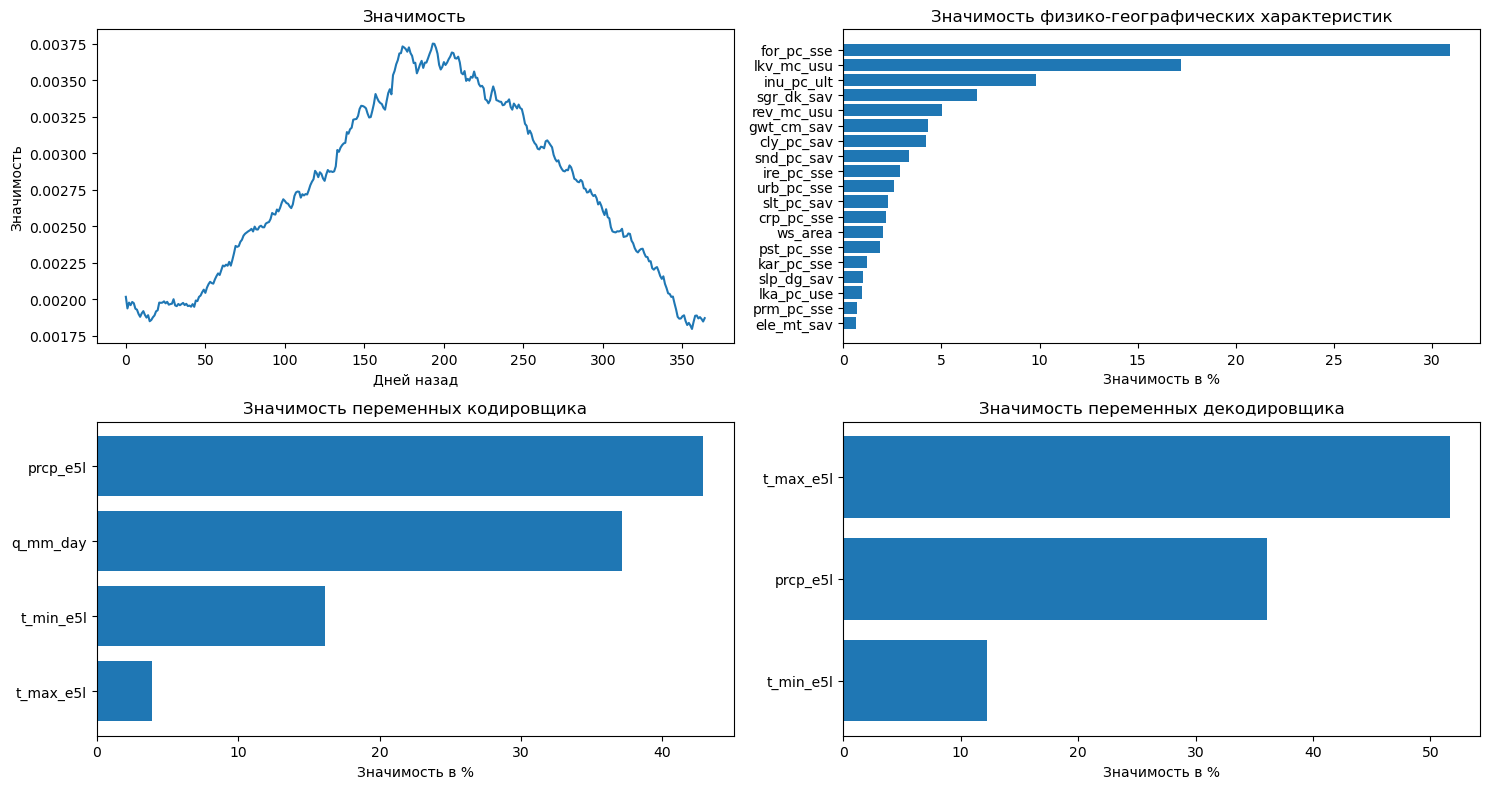

In [16]:
fig, axs = plt.subplots(figsize=(15, 8),
                        ncols=2,
                        nrows=2)
# attention
attention = interpretation["attention"].detach().cpu()
attention = attention / attention.sum(-1).unsqueeze(-1)
axs[0, 0].plot(
    np.arange(0, 365), attention
)
axs[0, 0].set_xlabel("Дней назад")
axs[0, 0].set_ylabel("Значимость")
axs[0, 0].set_title("Значимость")


make_selection_plot(
    "Значимость физико-географических характеристик", interpretation["static_variables"].detach().cpu(), static_parameters,
    ax=axs[0, 1]);
make_selection_plot(
    "Значимость переменных кодировщика",
    interpretation["encoder_variables"].detach().cpu(),
    [*meteo_input, hydro_target],
    ax=axs[1, 0])
make_selection_plot(
    "Значимость переменных декодировщика",
    interpretation["decoder_variables"].detach().cpu(),
    meteo_input,
    ax=axs[1, 1]);
fig.savefig('../conclusions/images/interp_model.png',
            dpi=650, bbox_inches='tight')


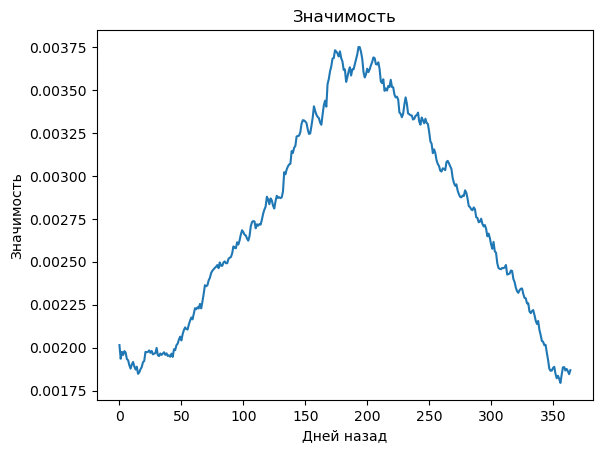

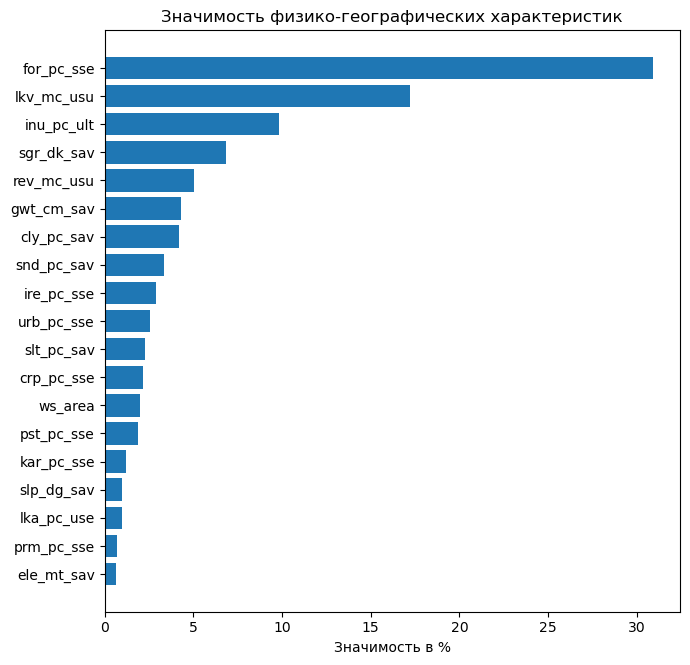

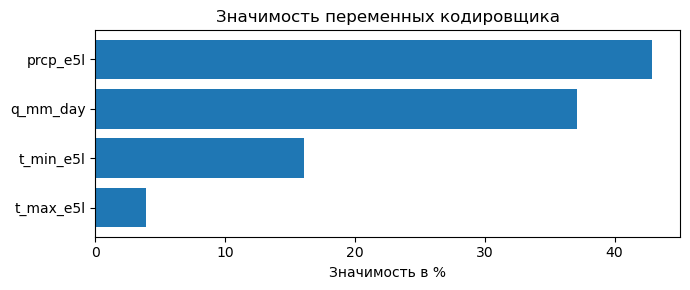

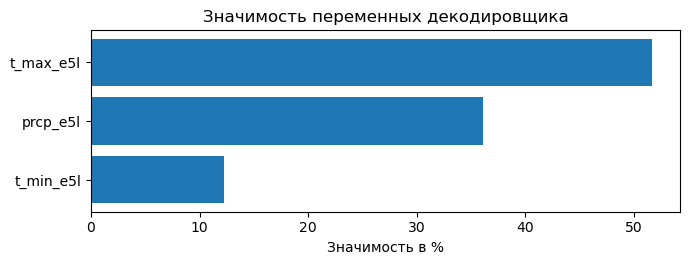

In [16]:
figs = {}
# attention
fig, ax = plt.subplots()
attention = interpretation["attention"].detach().cpu()
attention = attention / attention.sum(-1).unsqueeze(-1)
ax.plot(
    np.arange(0, 365), attention
)
ax.set_xlabel("Дней назад")
ax.set_ylabel("Значимость")
ax.set_title("Значимость")
figs["attention"] = fig

# variable selection
def make_selection_plot(title, values, labels):
    fig, ax = plt.subplots(figsize=(7, len(values) * 0.25 + 2))
    order = np.argsort(values)
    values = values / values.sum(-1).unsqueeze(-1)
    ax.barh(np.arange(len(values)), values[order] * 100, tick_label=np.asarray(labels)[order])
    ax.set_title(title)
    ax.set_xlabel("Значимость в %")
    plt.tight_layout()
    return fig

figs["static_variables"] = make_selection_plot(
    "Значимость физико-географических характеристик", interpretation["static_variables"].detach().cpu(), static_parameters
)
figs["encoder_variables"] = make_selection_plot(
    "Значимость переменных кодировщика", interpretation["encoder_variables"].detach().cpu(), [*meteo_input, hydro_target],
)
figs["decoder_variables"] = make_selection_plot(
    "Значимость переменных декодировщика", interpretation["decoder_variables"].detach().cpu(), meteo_input
)
fig, axs = plt.subplots(figsize=(15, 8),
                        ncols=2,
                        nrows=2)


In [106]:
partial_gauges = gpd.read_file(
    '../geo_data/great_db/geometry/gauges_partial_q.gpkg')
partial_gauges.index = partial_gauges['gauge_id'].astype(str)
partial_ws = ws_file[ws_file.index.isin(partial_gauges.index)]
partial_ws

,name_ru,name_en,new_area,ais_dif,geometry
gauge_id,,,,,
9122,р.Тапса - с.Кара-Хак,r.Tapsa - s.Kara-Hak,1177.695,0.658,"POLYGON ((94.79542 52.07792, 94.79625 52.07792..."
9124,р.Малый Енисей - пос.Усть-Ужеп,r.Malyj Enisej - pos.Ust'-Uzhep,40506.920,4.239,"POLYGON ((98.72042 52.29125, 98.72042 52.29042..."
9134,р.Мизин - пос.Сизим,r.Mizin - pos.Sizim,888.693,2.502,"POLYGON ((95.93958 51.32792, 95.94292 51.32792..."
9138,р.Элегест - пгт.Хову-Аксы,r.Elegest - pgt.Hovu-Aksy,1977.104,6.871,"POLYGON ((93.19208 51.32958, 93.19208 51.32875..."
9204,р.Минусинка - г.Минусинск,r.Minusinka - g.Minusinsk,213.892,3.216,"POLYGON ((91.88375 53.82542, 91.88542 53.82542..."
...,...,...,...,...,...
10378,р.Большой Улуй - д.Ольховка,r.Bol'shoj Uluj - d.Ol'hovka,1103.041,1.196,"POLYGON ((90.27292 56.14708, 90.27292 56.15208..."
10342,р.Сереж - д.Корнилово,r.Serezh - d.Kornilovo,1627.751,1.734,"POLYGON ((89.95708 55.39708, 89.95708 55.39792..."
10103,р.Сема - с.Шебалино,r.Sema - s.Shebalino,498.421,0.316,"POLYGON ((85.55875 51.31042, 85.55875 51.30958..."


In [37]:
lost_gauges = gpd.read_file('../geo_data/great_db/geometry/lost_gauges.gpkg')
lost_gauges.index = lost_gauges['gauge_id'].astype(str)
lost_ws = ws_file[ws_file.index.isin(lost_gauges.index)]

In [ ]:
meteo_input = ['prcp_e5l',  't_max_e5l', 't_min_e5l']
hydro_target = 'q_mm_day'
static_parameters = ['for_pc_sse', 'crp_pc_sse',
                     'inu_pc_ult', 'ire_pc_sse',
                     'lka_pc_use', 'prm_pc_sse',
                     'pst_pc_sse', 'cly_pc_sav',
                     'slt_pc_sav', 'snd_pc_sav',
                     'kar_pc_sse', 'urb_pc_sse',
                     'gwt_cm_sav', 'lkv_mc_usu',
                     'rev_mc_usu', 'sgr_dk_sav',
                     'slp_dg_sav', 'ws_area',
                     'ele_mt_sav']
res_list = list()
for nc_file in [file for file
                in glob.glob('../geo_data/great_db/nc_concat/*.nc')
                if file.split('/')[-1][:-3] in lost_ws.index]:
    gauge_id = nc_file.split('/')[-1][:-3]
    file = open_for_tft(
        nc_files=[nc_file],
        static_path='../geo_data/attributes/geo_vector.csv',
        area_index=lost_ws.index,
        meteo_predictors=meteo_input,
        hydro_target=hydro_target, allow_nan=True)
    try:
        (train_ds, train_loader,
         val_ds, val_loader, val_df,
         scaler) = train_val_split(file)

        res_df, interpretation = pred_res_builder(gauge_id=gauge_id,
                                                  hydro_target=hydro_target,
                                                  meteo_input=meteo_input,
                                                  static_parameters=static_parameters,
                                                  model_checkpoint='/workspaces/my_dissertation/forecast/TFT_914/lightning_logs/version_0/checkpoints/epoch=2-step=78123.ckpt',
                                                  res_storage='./result/lost_gauge',
                                                  val_df=val_df,
                                                  scaler=scaler,
                                                  val_ts_ds=val_ds, with_plot=False)
        res_list.append(res_df)
    except AssertionError:
        print(f'No available data for {gauge_id}')
pd.concat(res_list).to_csv('./result/tft_lost_gauge.csv', index=False)

### Blind forecast

In [5]:
meteo_input = ['prcp_e5l',  't_max_e5l', 't_min_e5l']
hydro_target = 'q_mm_day'
static_parameters = ['for_pc_sse', 'crp_pc_sse',
                     'inu_pc_ult', 'ire_pc_sse',
                     'lka_pc_use', 'prm_pc_sse',
                     'pst_pc_sse', 'cly_pc_sav',
                     'slt_pc_sav', 'snd_pc_sav',
                     'kar_pc_sse', 'urb_pc_sse',
                     'gwt_cm_sav', 'lkv_mc_usu',
                     'rev_mc_usu', 'sgr_dk_sav',
                     'slp_dg_sav', 'ws_area',
                     'ele_mt_sav']

partial_gauges = gpd.read_file(
    '../geo_data/great_db/geometry/gauges_partial_q.gpkg')
partial_gauges.index = partial_gauges['gauge_id'].astype(str)
partial_ws = ws_file[ws_file.index.isin(partial_gauges.index)]

res_list = list()
for nc_file in [file for file
                in glob.glob('../geo_data/great_db/nc_concat/*.nc')
                if file.split('/')[-1][:-3] in partial_ws.index]:
    gauge_id = nc_file.split('/')[-1][:-3]
    file = open_for_tft(
        nc_files=[nc_file],
        static_path='../geo_data/attributes/geo_vector.csv',
        area_index=partial_ws.index,
        meteo_predictors=meteo_input,
        hydro_target=hydro_target, allow_nan=True)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [17]:
open_for_tft(
        nc_files=[nc_file],
        static_path='../geo_data/attributes/geo_vector.csv',
        area_index=partial_ws.index,
        meteo_predictors=meteo_input,
        hydro_target=hydro_target, allow_nan=True)

,date,gauge_id,lvl_sm,q_cms_s,lvl_mbs,q_mm_day,t_max_e5l,t_max_e5,t_min_e5l,t_min_e5,...,swc_pc_s09,swc_pc_s10,swc_pc_s11,swc_pc_s12,kar_pc_sse,ero_kh_sav,urb_pc_sse,hft_ix_s93,hft_ix_s09,ws_area
0,2008-01-01,5313,147.0,0.98,352.77,0.042583,-11.895184,-11.792572,-20.711845,-20.659493,...,100.0,100.0,100.0,100.0,0.0,323.03125,0.0,1.2,0.08125,1987.707928
1,2008-01-02,5313,147.0,0.97,352.77,0.042149,-14.405705,-14.361055,-22.471332,-22.365073,...,100.0,100.0,100.0,100.0,0.0,323.03125,0.0,1.2,0.08125,1987.707928
2,2008-01-03,5313,147.0,0.96,352.77,0.041714,-13.001947,-12.958592,-19.864073,-19.782471,...,100.0,100.0,100.0,100.0,0.0,323.03125,0.0,1.2,0.08125,1987.707928
3,2008-01-04,5313,147.0,0.95,352.77,0.041280,-16.658846,-16.576197,-24.456642,-24.277232,...,100.0,100.0,100.0,100.0,0.0,323.03125,0.0,1.2,0.08125,1987.707928
4,2008-01-05,5313,148.0,0.94,352.78,0.040845,-14.072878,-14.016891,-21.116788,-21.017483,...,100.0,100.0,100.0,100.0,0.0,323.03125,0.0,1.2,0.08125,1987.707928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744,2020-12-27,5313,134.0,NaN,352.64,NaN,-18.809981,-18.784555,-29.544360,-29.451454,...,100.0,100.0,100.0,100.0,0.0,323.03125,0.0,1.2,0.08125,1987.707928
4745,2020-12-28,5313,135.0,NaN,352.65,NaN,-21.116141,-21.062365,-28.503795,-28.457926,...,100.0,100.0,100.0,100.0,0.0,323.03125,0.0,1.2,0.08125,1987.707928
4746,2020-12-29,5313,135.0,NaN,352.65,NaN,-25.763021,-25.699042,-34.277711,-34.184639,...,100.0,100.0,100.0,100.0,0.0,323.03125,0.0,1.2,0.08125,1987.707928
4747,2020-12-30,5313,136.0,NaN,352.66,NaN,-25.874428,-25.792402,-32.891165,-32.829868,...,100.0,100.0,100.0,100.0,0.0,323.03125,0.0,1.2,0.08125,1987.707928


In [9]:
static_attributes = pd.read_csv('../geo_data/attributes/geo_vector.csv',
                                index_col='gauge_id')
static_attributes.index = static_attributes.index.astype(str)
static_attributes

,inu_pc_ult,lka_pc_use,lkv_mc_usu,rev_mc_usu,dor_pc_pva,gwt_cm_sav,ele_mt_sav,slp_dg_sav,sgr_dk_sav,clz_cl_smj,...,swc_pc_s09,swc_pc_s10,swc_pc_s11,swc_pc_s12,kar_pc_sse,ero_kh_sav,urb_pc_sse,hft_ix_s93,hft_ix_s09,ws_area
gauge_id,,,,,,,,,,,,,,,,,,,,,
9002,0.941118,0.641118,389.603792,0.000000,0.000000,303.030938,1571.781437,11.622156,205.109780,6.579840,...,63.911178,65.323353,67.924152,70.619760,14.243513,1824.591816,0.063872,1.504890,1.544810,1.150773e+05
9022,0.904642,0.506085,730.792974,117.816813,0.255960,317.652447,1515.685069,12.305270,225.447302,6.698243,...,61.784191,63.599749,66.635508,69.755960,16.825596,1732.810540,0.069009,2.267880,2.348306,1.843211e+05
9053,0.786220,0.479685,1774.628346,1056.496063,1.452008,284.435433,1225.637402,11.221732,199.254825,6.843701,...,62.071260,64.652362,68.509449,72.198819,26.519685,1295.847244,0.239764,3.472047,2.874016,3.029110e+05
9112,1.119497,1.368553,245.679245,0.000000,0.000000,257.786164,1530.132075,9.515094,174.088050,6.622642,...,63.553459,64.679245,66.974843,69.559748,0.000000,1019.779874,0.000000,0.222642,0.251572,1.542277e+04
9115,0.690647,0.985372,428.083933,0.000000,0.000000,284.000000,1478.561151,10.741247,192.503597,6.534772,...,73.175060,75.011990,77.872902,80.625899,17.328537,1513.930456,0.000000,0.660432,0.622542,4.485384e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056,7.163294,1.721503,1817.545188,919.802507,6.016179,55.814013,387.238515,1.822415,47.623831,7.722447,...,38.786638,41.612791,46.690471,51.657621,3.046021,323.516782,0.508530,7.551218,8.277616,1.537509e+06
11061,9.421580,1.884396,2082.438281,988.848969,5.692448,52.095847,360.204255,1.768291,45.281830,7.661124,...,41.227345,44.356157,49.709773,54.900886,2.787467,296.880046,0.473570,7.043596,7.714362,1.690572e+06
11801,12.069941,1.696061,2775.850899,848.193018,3.405397,55.990529,322.955725,2.371864,51.390265,7.350878,...,50.899635,55.313246,61.940242,67.747810,3.520010,281.911201,0.447806,5.608930,5.942505,2.996808e+06


In [15]:
static_attributes.empty

False

In [79]:
static_attributes = pd.read_csv('../geo_data/attributes/geo_vector.csv',
                                index_col='gauge_id')
static_attributes.index = static_attributes.index.astype(str)
gauge_id = nc_file.split('/')[-1][:-3]
res_file = list()
try:
    gauge_static = static_attributes.loc[[gauge_id], :]
except KeyError:
    print(f'No data for {gauge_id} !')

else:
    file = xr.open_dataset(nc_file)
    file = file.to_dataframe()
    # file['date'] = file.index
    file = file.reset_index()
    file['time_idx'] = file.index

    for col in gauge_static.columns:
        file[col] = gauge_static.loc[gauge_id, col]

    res_file.append(file)

In [ ]:
f = open_for_tft(
        nc_files=[nc_file],
        static_path='../geo_data/attributes/geo_vector.csv',
        area_index=lost_ws.index,
        meteo_predictors=meteo_input,
        hydro_target=hydro_target, allow_nan=True)

In [73]:
if 'index' in f.columns:
    f = f.rename(columns={'index': 'date'})
f = f[['date', 'time_idx', 'gauge_id',
                    hydro_target, *meteo_input, *static_parameters]]
f = f.dropna().reset_index(drop=True)

scaler = MinMaxScaler(feature_range=(1, 10))
f[[hydro_target, *meteo_input,
        *static_parameters]] = scaler.fit_transform(
    f[[hydro_target, *meteo_input, *static_parameters]])

### Run this to get results

In [7]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import pytorch_lightning as pl
from scripts.tft_data import open_for_tft, train_val_split
from scripts.model_eval import nnse, pred_res_builder

import glob
import geopandas as gpd
import pandas as pd
from tqdm import tqdm

import torch
torch.set_float32_matmul_precision('medium')


# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')


meteo_input = ['prcp_e5l',  't_max_e5l', 't_min_e5l']
hydro_target = 'q_mm_day'
static_parameters = ['for_pc_sse', 'crp_pc_sse',
                     'inu_pc_ult', 'ire_pc_sse',
                     'lka_pc_use', 'prm_pc_sse',
                     'pst_pc_sse', 'cly_pc_sav',
                     'slt_pc_sav', 'snd_pc_sav',
                     'kar_pc_sse', 'urb_pc_sse',
                     'gwt_cm_sav', 'lkv_mc_usu',
                     'rev_mc_usu', 'sgr_dk_sav',
                     'slp_dg_sav', 'ws_area',
                     'ele_mt_sav']

ws_file = gpd.read_file('../geo_data/great_db/geometry/russia_ws.gpkg')
ws_file = ws_file.set_index('gauge_id')
# ws_file = ws_file[ws_file['new_area'] <= 50000]


###############################################################################
file = open_for_tft(
    nc_files=glob.glob('../geo_data/great_db/nc_all_q/*.nc'),
    static_path='../geo_data/attributes/geo_vector.csv',
    area_index=ws_file.index,
    meteo_predictors=meteo_input,
    hydro_target=hydro_target,
    with_static=False)

(train_ds, train_loader,
    val_ds, val_loader, val_df,
    scaler) = train_val_split(file, with_static=False)
res = list()
for gauge in tqdm(val_df.gauge_id.unique()):
    res.append(pred_res_builder(gauge_id=gauge,
                                res_storage='./result/tft_no_static_20epoch_256_RMSE/',
                                model_checkpoint='/workspaces/my_dissertation/forecast/multi_gauge_256_no_static/lightning_logs/version_0/checkpoints/epoch=20-step=299376.ckpt',
                                hydro_target=hydro_target,
                                meteo_input=meteo_input,
                                static_parameters=[],
                                val_ts_ds=val_ds, val_df=val_df,
                                scaler=scaler,
                                with_plot=False)[0])
res = pd.concat(res)
res.to_csv('./result/tft_no_static_pred_20epoch_RMSE_256.csv',
           index=False)

Using device: cuda

NVIDIA GeForce RTX 3080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


100%|██████████| 1112/1112 [34:55<00:00,  1.88s/it]


In [8]:
pd.read_csv('./result/tft_no_static_pred_20epoch_RMSE_256.csv')['NSE'].median()

0.9069555657311559

In [ ]:
best_tft = TemporalFusionTransformer.load_from_checkpoint(
    '/workspaces/my_dissertation/forecast/TFT_914/lightning_logs/version_6/checkpoints/epoch=20-step=246057.ckpt')
res = list()
for gauge in tqdm(val_df.gauge_id.unique()):
    res.append(pred_res_builder(gauge_id=gauge,
                                val_ts_ds=validation,
                                with_plot=False))
res = pd.concat(res)
res.to_csv('./result/tft_predictions_6.csv',
           index=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x675 with 1 Axes>,
 'encoder_variables': <Figure size 700x300 with 1 Axes>,
 'decoder_variables': <Figure size 700x275 with 1 Axes>}

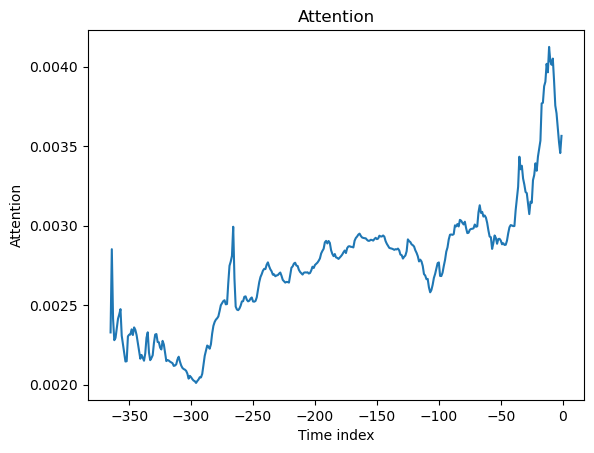

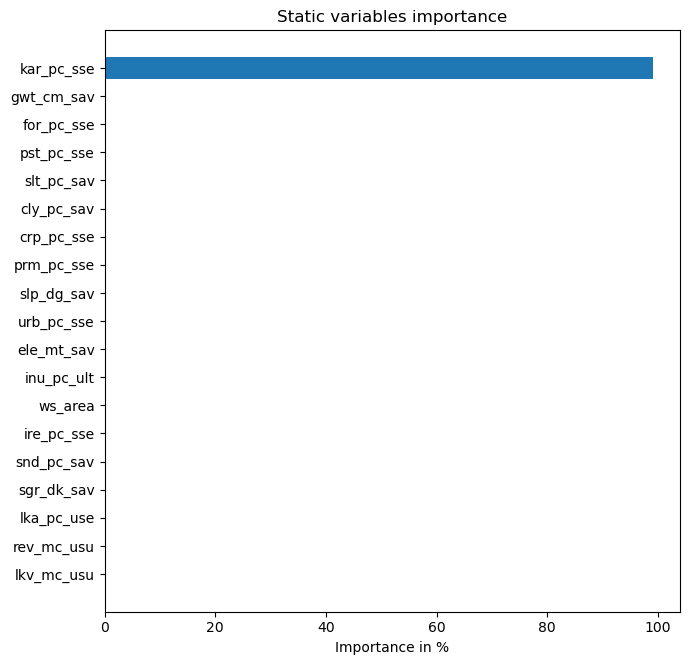

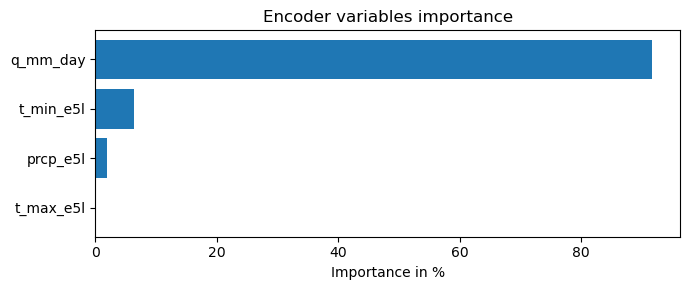

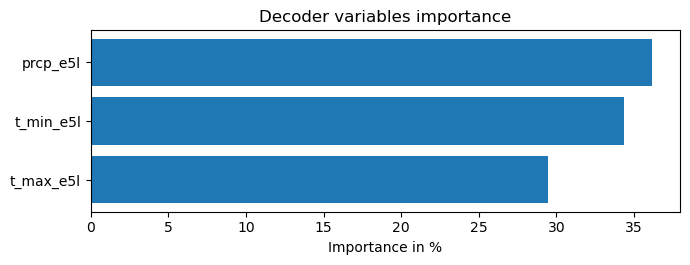

In [11]:
best_tft = TemporalFusionTransformer.load_from_checkpoint(
    '/workspaces/my_dissertation/forecast/multi_gauge_256/lightning_logs/version_0/checkpoints/epoch=20-step=274596.ckpt')


pred_id = '5461'
file = open_for_tft(
    nc_files=glob.glob(f'../geo_data/great_db/nc_all_q/{pred_id}.nc'),
    static_path='../geo_data/attributes/geo_vector.csv',
    area_index=ws_file.index,
    meteo_predictors=meteo_input,
    hydro_target=hydro_target)

(train_ds, train_loader,
    val_ds, val_loader, val_df,
    scaler) = train_val_split(file)

raw_predictions, _, x, _, _ = best_tft.predict(val_ds.filter(
    lambda x: x.gauge_id == f'{pred_id}').to_dataloader(train=False,
                                                   batch_size=128,
                                                   num_workers=8), mode="raw",
    return_x=True)
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)